# 정책 경사법을 활용한 미로게임

In [0]:
# 텐서 2.0 대비
! pip install tensorflow=1.15

ERROR: Invalid requirement: 'tensorflow=1.15'
Hint: = is not a valid operator. Did you mean == ?


In [0]:
# 모듈 가져오기
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# 애니메이션 처리
from matplotlib import animation
# 코렙에 html을 삽입하는 모듈
from IPython.display import HTML

In [0]:
# 게임 베이스 그리기 : 미로 게임판 생성
# 미로게임판은 입구과 출구가 각각 1개만 존재
# 바둑판 같은 사각형에 열린곳과 , 막힌곳이 존재
# 에이전트(마우스)는 4방향으로 이동이 가능 (상:0,우:1,하:2,좌:3, 시계방향)
# 게임판은 위에서 투시해서 직각으로 보는 뷰를 사용
# 게임판은 3x3이다

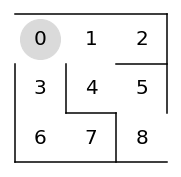

In [0]:
# 미로판의 크기1
fig = plt.figure( figsize=(3,3) )

# 벽그리기
#plt.plot( [x값들], [y값들], 칼라)
plt.plot( [0,3], [3,3], color='k' ) # 맨 상단 가로 벽
plt.plot( [0,3], [0,0], color='k' ) # 맨 하단 가로 벽
plt.plot( [0,0], [0,2], color='k' ) # 왼쪽 세로 벽  -> 입구
plt.plot( [3,3], [1,3], color='k' ) # 오른쪽 세로 벽 -> 출구
plt.plot( [1,1], [1,2], color='k' ) # 내부벽 
plt.plot( [2,3], [2,2], color='k' ) # 내부벽
plt.plot( [2,1], [1,1], color='k' ) # 내부벽
plt.plot( [2,2], [0,1], color='k' ) # 내부벽
# 각 포인트에 숫자 표현하기 : 연속적으로 그린다
for n in range(3):
    for m in range(3):
        plt.text( n+0.5, 3-m-0.5, str(n+m*3), size=20, ha='center', va='center' )

# 마우스 그리기 (원)
mouse = plt.plot( [0.5],[2.5], marker='o', color='#dadada', markersize=40 )

# 눈금, 테두리 정리
plt.tick_params( axis='both', which='both', bottom=False, top=False,
            labelbottom=False, right=False, left=False, labelleft=False )

# 화면에 보이기
plt.box(False)
plt.show()

# 개요

- 정책 결정의 방식
  - 에이전트가 행동을 결정하기 위해서 최적의 정책을 구한다
- 정책에 따라 행동
  - 판단의 기준은 성공
  - 이런 **성공을 얻는 행동을 많이 하도록** 정책을 갱신하는 방법
  - 정책 경사법

# 미션

- 에이전트가 시작지점(0번 위치)에서 상우하좌로 이동, 골인 지점(8번 위치)까지 최단 경로로 이동하는 것(최단 거리 학습)

# 요소 설계

|강화 학습 요소|미로 게임|
|:--:|:--|
|환경|미로|
|에이전트|미로속의 mouse|
|목적|골인 지점(8번)으로 이동, 미로탈출|
|에피소드|골인 지점까지 도착|
|상태|에이전트의 위치|
|행동|상하좌우 이동|
|보상|골인 지점까지 이동하는 행동을 중시하는 경향|
|학습방법|정책 경사법|
|파라미터 갱신|-정책 결정에 영향을 미친다(가중치 필터)<br>-정책은 행동에 영향을 미친다<br>-각 포인트별로 갈수 있는곳과 갈수 없는 곳에 대한 정보, 갈수 있는 곳의선택될 확률을 가지고 있다<br>-1 에피소드가 종료되면 갱신|

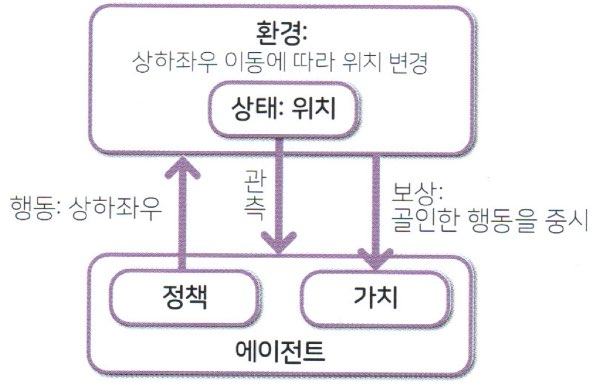

In [0]:
from IPython.display import Image
Image('/content/drive/My Drive/Colab Notebooks/2기/dl_data/미로게임_학습사이클.jpg', width='400')

# 정책

- 에이전트의 상태(미로상의 위치)
  - 이런 상태에서 특정 행동을 할 확률
  - 매개변수 혹은 파라미터로 표현
  - 정책을 묘사하기 위해서 각 포인트에서 취할 행동의 확률을 표현
  - (행동을 취할 포인트개수, 행동의 개수)

|--|상|우|하|좌|
|:--:|:--:|:--:|:--:|:--:|
|p0|np.nan|1|1|np.nan|
|p1|np.nan|1|1|1|
|p2|--|--|--|--|
|p3|--|--|--|--|
|p4|--|--|--|--|
|p5|--|--|--|--|
|p6|--|--|--|--|
|p7|--|--|--|--|



## softmax 함수를 통과시켜서 처리하면

|--|상|우|하|좌|
|:--:|:--:|:--:|:--:|:--:|
|p0|0|0.5|0.5|0|
|p1|0|0.333|0.333|0.333|
|p2|--|--|--|--|
|p3|--|--|--|--|
|p4|--|--|--|--|
|p5|--|--|--|--|
|p6|--|--|--|--|
|p7|--|--|--|--|

In [0]:
# 파라미터 θ의 초기값 준비
# 미로게임판을 기반으로 설계 (차후에 자동화하면 좋겟다)
theta_0 = np.array([
  # [상, 우, 하, 좌], 
  [ np.nan, 1, 1,np.nan ], # 0
  [ np.nan, 1, 1,1 ], # 1
  [ np.nan, np.nan, np.nan,1 ], # 2
  [ 1,np.nan , 1,np.nan ], # 3
  [1 , 1, np.nan, np.nan], # 4
  [ np.nan, np.nan, 1, 1], # 5
  [ 1, 1, np.nan,np.nan ], # 6
  [ np.nan, np.nan, np.nan, 1], # 7 포인트  
])
# 8 포인트는 골인 지점이므로 매개변수를 고려하지 않음

In [0]:
theta_0

array([[nan,  1.,  1., nan],
       [nan,  1.,  1.,  1.],
       [nan, nan, nan,  1.],
       [ 1., nan,  1., nan],
       [ 1.,  1., nan, nan],
       [nan, nan,  1.,  1.],
       [ 1.,  1., nan, nan],
       [nan, nan, nan,  1.]])

In [0]:
# 확률 = 개별값/전체총합
a = theta_0[0]
# nan을 0으로 처리하고 계산한다, 합산
a / np.nansum(a)

array([nan, 0.5, 0.5, nan])

In [0]:
a = theta_0[0]
b = np.exp(a)   # 지수함수 
b, b/np.nansum(b)

(array([       nan, 2.71828183, 2.71828183,        nan]),
 array([nan, 0.5, 0.5, nan]))

In [0]:
# nan을 0으로 변환, nan을 수치로 변환
np.nan_to_num(b/np.nansum(b))

array([0. , 0.5, 0.5, 0. ])

In [0]:
# softmax 처리 함수 구현, 사용
# label이 다항인 경우, 3-class 이상의 분류를 목적으로 하는 딥러닝 모델의 
# 출력층으로 보내는 활성화 함수
# softmax을 처리한 구성원들의 총합이 1이 된다 => 행동결정의 확률
# 0~1사이로 theta_0가 만들어져야 하위 작업을 진행
def mySoftmax( theta ):
  # 1. theta와 같은 크기로 배열을 생성, 초기값은 0
  # 2. theta를 지수함수로 처리
  pass

In [0]:
# 정책에 따른 행동 정보 획득 

In [0]:
# 행동에 따른 다음 상태(위치 정보) 획득

In [0]:
# 시뮬레이션 준비

In [0]:
# 정책경사법을 적용한, 파라미터 θ 갱신 처리(핵심)

In [0]:
# 에피소드 반복 처리(1000번)

In [0]:
  # 최단거리 이동 시뮬레이션 드로잉(자동연출)